In [1]:
import json
# import ast

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from catboost import CatBoostClassifier, Pool, metrics, EFeaturesSelectionAlgorithm
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
# from transformers import AutoTokenizer
# import torch
import shap

from pandarallel import pandarallel
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # to manipulate x-tickers
import plotly.express as px
from Levenshtein import distance as lev_distance

import os
from tqdm import tqdm
import random
from collections import Counter
import pickle
import warnings

from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize': (20, 10), 'figure.facecolor': 'white'})
sns.set_palette("viridis")
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
os.environ["TOKENIZERS_PARALLELISM"] = "true"  # activate parallelism
pandarallel.initialize(progress_bar=True)
InteractiveShell.ast_node_interactivity = "all"  # show all outputs, not only the last

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
data = pd.read_csv("../data/raw/train_dataset_Самолет.csv")

In [3]:
# data

In [4]:
# delete nearly null features
data

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,col40,col41,col42,col43,col44,col45,col46,col47,col48,col49,col50,col51,col52,col53,col54,col55,col56,col57,col58,col59,col60,col61,col62,col63,col64,col65,col66,col67,col68,col69,col70,col71,col72,col73,col74,col75,col76,col77,col78,col79,col80,col81,col82,col83,col84,col85,col86,col87,col88,col89,col90,col91,col92,col93,col94,col95,col96,col97,col98,col99,col100,col101,col102,col103,col104,col105,col106,col107,col108,col109,col110,col111,col112,col113,col114,col115,col116,col117,col118,col119,col120,col121,col122,col123,col124,col125,col126,col127,col128,col129,col130,col131,col132,col133,col134,col135,col136,col137,col138,col139,col140,col141,col142,col143,col144,col145,col146,col147,col148,col149,col150,col151,col152,col153,col154,col155,col156,col157,col158,col159,col160,col161,col162,col163,col164,col165,col166,col167,col168,col169,col170,col171,col172,col173,col174,col175,col176,col177,col178,col179,col180,col181,col182,col183,col184,col185,col186,col187,col188,col189,col190,col191,col192,col193,col194,col195,col196,col197,col198,col199,col200,col201,col202,col203,col204,col205,col206,col207,col208,col209,col210,col211,col212,col213,col214,col215,col216,col217,col218,col219,col220,col221,col222,col223,col224,col225,col226,col227,col228,col229,col230,col231,col232,col233,col234,col235,col236,col237,col238,col239,col240,col241,col242,col243,col244,col245,col246,col247,...,col2414,col2415,col2416,col2417,col2418,col2419,col2420,col2421,col2422,col2423,col2424,col2425,col2426,col2427,col2428,col2429,col2430,col2431,col2432,col2433,col2434,col2435,col2436,col2437,col2438,col2439,col2440,col2441,col2442,col2443,col2444,col2445,col2446,col2447,col2448,col2449,col2450,col2451,col2452,col2453,col2454,col2455,col2456,col2457,col2458,col2459,col2460,col2461,col2462,col2463,col2464,col2465,col2466,col2467,col2468,col2469,col2470,col2471,col2472,col2473,col2474,col2475,col2476,col2477,col2478,col2479,col2480,col2481,col2482,col2483,col2484,col2485,col2486,col2487,col2488,col2489,col2490,col2491,col2492,col2493,col2494,col2495,col2496,col2497,col2498,col2499,col2500,col2501,col2502,col2503,col2504,col2505,col2506,col2507,col2508,col2509,col2510,col2511,col2512,col2513,col2514,col2515,col2516,col2517,col2518,col2519,col2520,col2521,col2522,col2523,col2524,col2525,col2526,col2527,col2528,col2529,col2530,col2531,col2532,col2533,col2534,col2535,col2536,col2537,col2538,col2539,col2540,col2541,col2542,col2543,col2544,col2545,col2546,col2547,col2548,col2549,col2550,col2551,col2552,col2553,col2554,col2555,col2556,col2557,col2558,col2559,col2560,col2561,col2562,col2563,col2564,col2565,col2566,col2567,col2568,col2569,col2570,col2571,col2572,col2573,col2574,col2575,col2576,col2577,col2578,col2579,col2580,col2581,col2582,col2583,col2584,col2585,col2586,col2587,col2588,col2589,col2590,col2591,col2592,col2593,col2594,col2595,col2596,col2597,col2598,col2599,col2600,col2601,col2602,col2603,col2604,col2605,col2606,col2607,col2608,col2609,col2610,col2611,col2612,col2613,col2614,col2615,col2616,col2617,col2618,col2619,col2620,col2621,col2622,col2623,col2624,col2625,col2626,col2627,col2628,col2629,col2630,col2631,col2632,col2633,col2634,col2635,col2636,col2637,col2638,col2639,col2640,col2641,col2642,col2643,col2644,col2645,col2646,col2647,col2648,col2649,col2650,col2651,col2652,col2653,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2022-11-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True


seed_everything()

In [6]:
def get_column_indices(df: pd.DataFrame, column_names: list) -> list:
    return [df.columns.get_loc(c) for c in column_names if c in df.columns]

In [7]:
def plot_roc_curve(model, X_test, y_test):
    # Predict probabilities for the test data.
    y_probs = model.predict_proba(X_test)

    # Keep only the positive class
    y_probs = y_probs[:, 1]

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)

    # Compute the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Feature Engineering 

In [8]:
def create_features(data):
    data['day'] = pd.to_datetime(data['report_date']).dt.day
    data['week'] = pd.to_datetime(data['report_date']).dt.week
    data['weekday'] = pd.to_datetime(data['report_date']).dt.weekday
    data['month'] = pd.to_datetime(data['report_date']).dt.month
    data['year'] = pd.to_datetime(data['report_date']).dt.year
    return data

In [9]:
data = create_features(data)

In [10]:
set(data.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

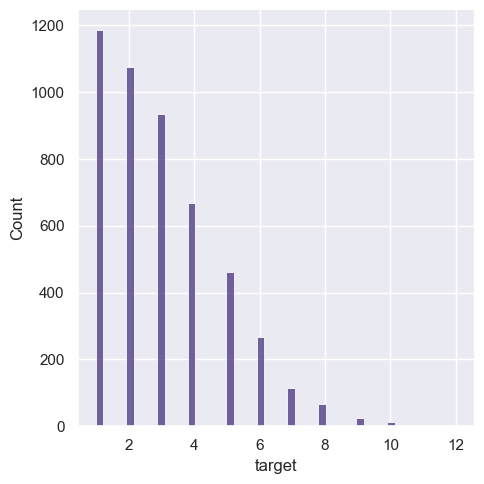

In [11]:
# plot data
plt_data = data[['client_id', 'target']].groupby('client_id', as_index=True)['target'].count()
ax = sns.displot(plt_data)
plt.show()

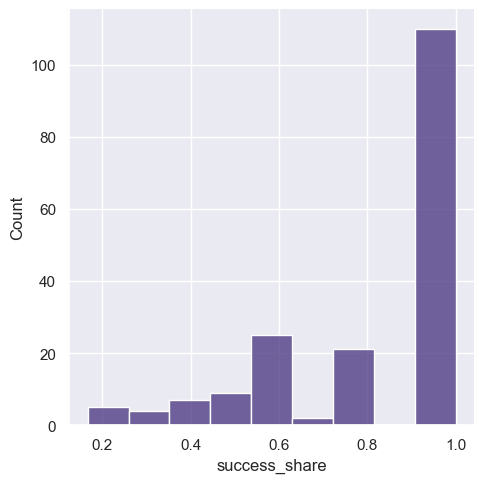

In [12]:
plt_data = data[['client_id', 'target']].groupby('client_id', as_index=True).agg(qnt=('target', 'count'), sum=('target', 'sum'))
plt_data['success_share'] = plt_data['sum'] / plt_data['qnt']
ax = sns.displot(plt_data.query("success_share > 0").success_share)
plt.show()

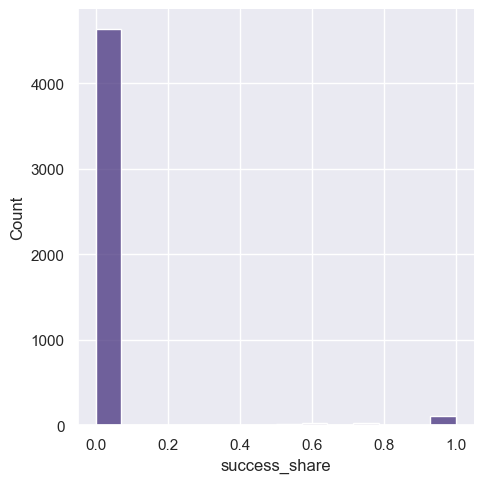

In [13]:
ax = sns.displot(plt_data.success_share)

In [14]:
print('entries per client')
data['client_id'].size / data['client_id'].unique().size

entries per client


3.001037990450488

In [15]:
X = data.drop(columns=['target', 'client_id', 'report_date'])
Y = data['target']

In [16]:
categorical_columns = X.select_dtypes(exclude=['float64', 'int64']).columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

In [17]:
X[numerical_columns] = X[numerical_columns].fillna(0)

In [18]:
X[categorical_columns] = X[categorical_columns].astype(str)

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.33, random_state=42, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.33, random_state=42, shuffle=True)

# Model

In [20]:
def catboost_model_classifier(x_train, x_test, y_train, y_test):
    # categorical_features_indices = np.where(~X_train.dtypes.isin(['float64', 'int64']))[0]
    categorical_columns = data.select_dtypes(exclude=['float64', 'int64']).columns
    categorical_features_indices = get_column_indices(x_train, categorical_columns)

    cb_model = CatBoostClassifier(
        loss_function='Logloss',
        random_seed=42,
        logging_level='Silent',
        # custom_metric=['MAE', 'MAPE'],
        max_depth=8,
        iterations=200,
        # scale_pos_weight=26,
        auto_class_weights='Balanced',
        early_stopping_rounds=20,
        # eval_metric=[metrics.Precision(), metrics.Recall(), metrics.F1(), metrics.TotalF1(), metrics.Accuracy()]
    )

    cb_model.fit(
        x_train, y_train,
        eval_set=(x_test, y_test),
        cat_features=categorical_features_indices,
        plot=True
    )

    return cb_model


In [21]:
model = catboost_model_classifier(X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
y_pred = model.predict(X_valid)

In [23]:
roc_auc_score(y_valid, y_pred)

0.9089717741935484

<Figure size 1200x1000 with 0 Axes>

<Axes: xlabel='Importances', ylabel='Feature Id'>

Text(0.5, 1.0, 'CatBoost features importance:')

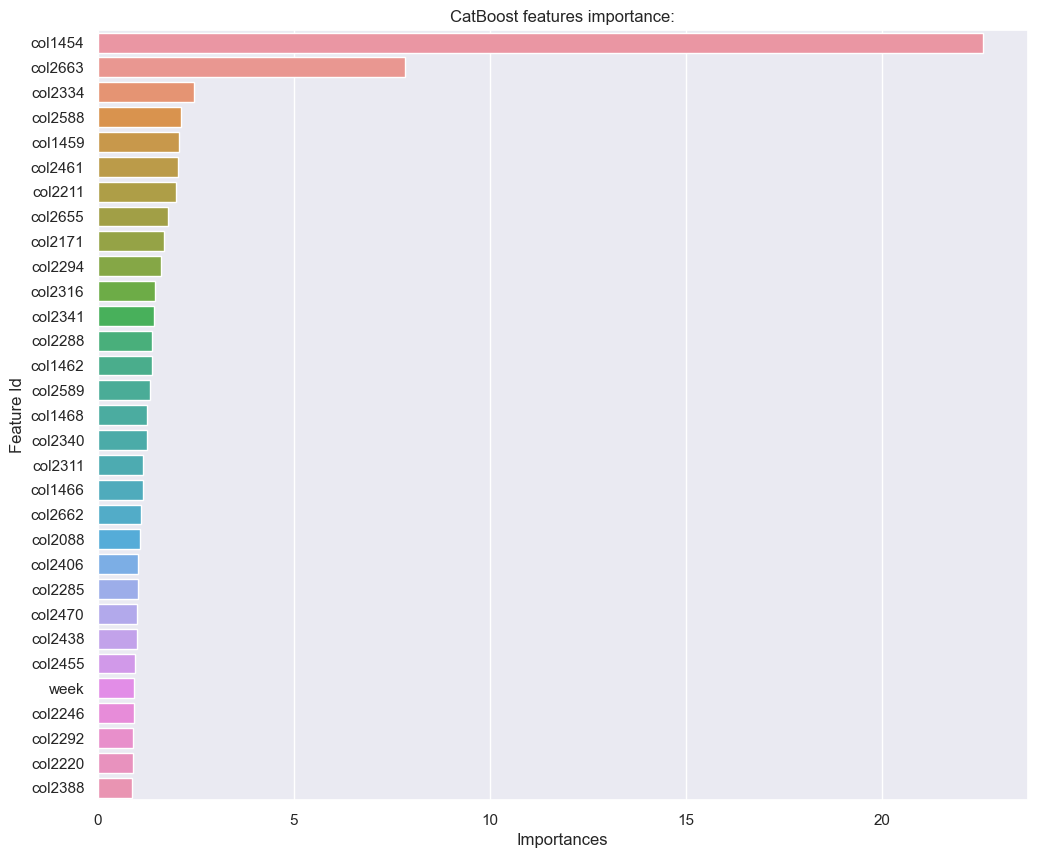

In [24]:
feat_importances = model.get_feature_importance(prettified=True)

plt.figure(figsize=(12, 10))
sns.barplot(x="Importances", y="Feature Id", data=feat_importances.loc[:30, :])
plt.title('CatBoost features importance:')

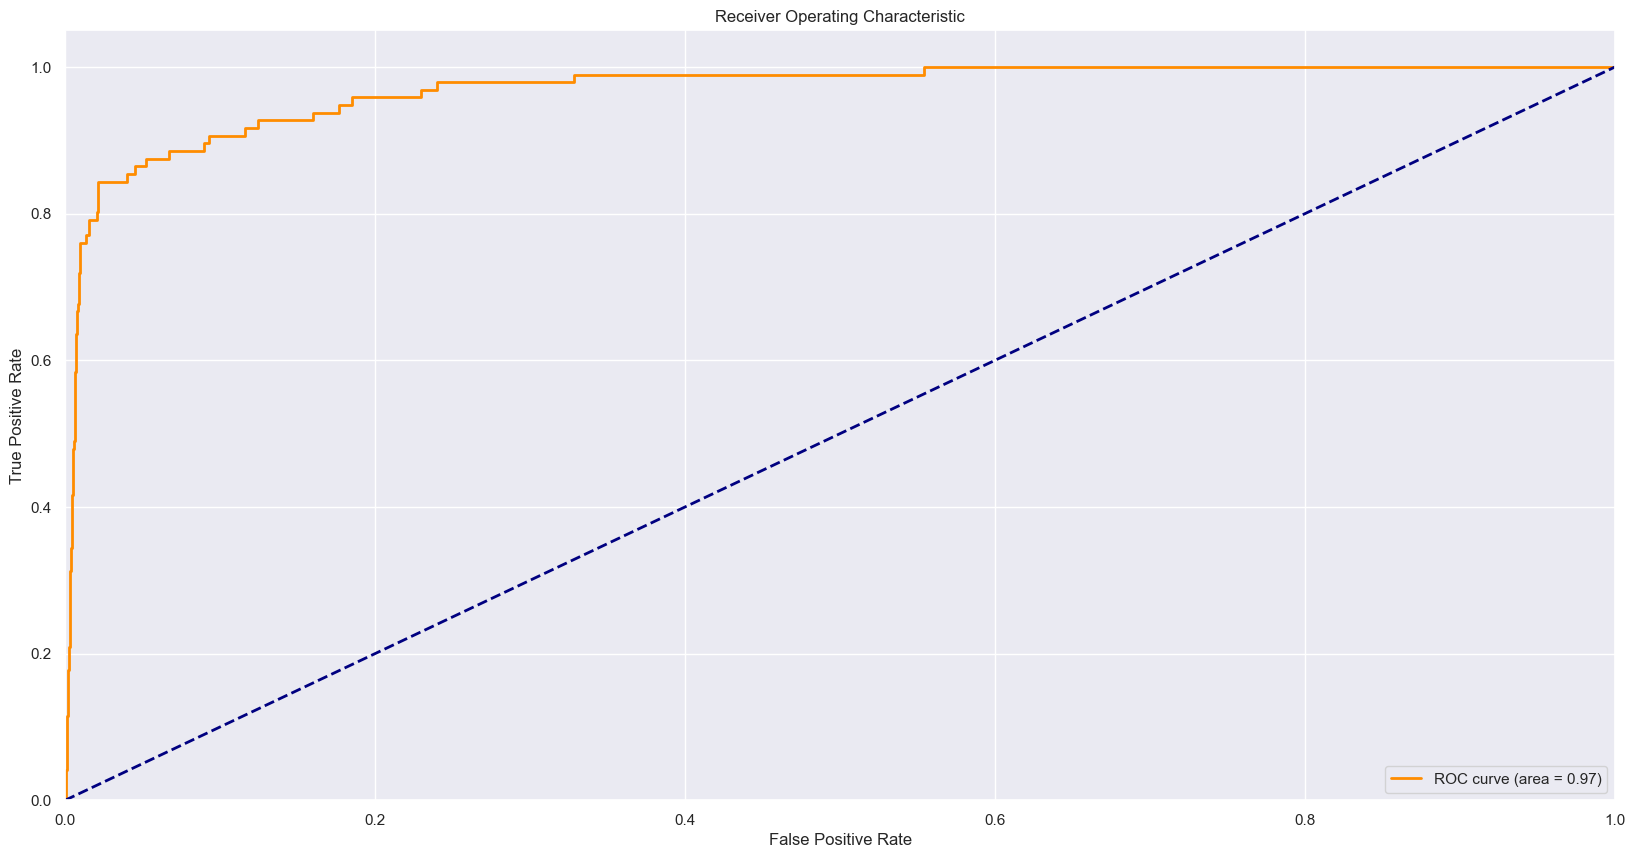

In [25]:
plot_roc_curve(model, X_valid, y_valid)

# Feature Selection

# Option 1

In [26]:
perm_raw = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=10)

In [27]:
perm = (
    pd.DataFrame(columns=['AVG_Importance', 'STD_Importance'], index=[i for i in X_train.columns])
    .assign(AVG_Importance=perm_raw.importances_mean)
    .assign(STD_Importance=np.std(perm_raw.importances, axis=1))
    .sort_values(by='AVG_Importance', ascending=False)
)

<Axes: ylabel='AVG_Importance'>

([], [])

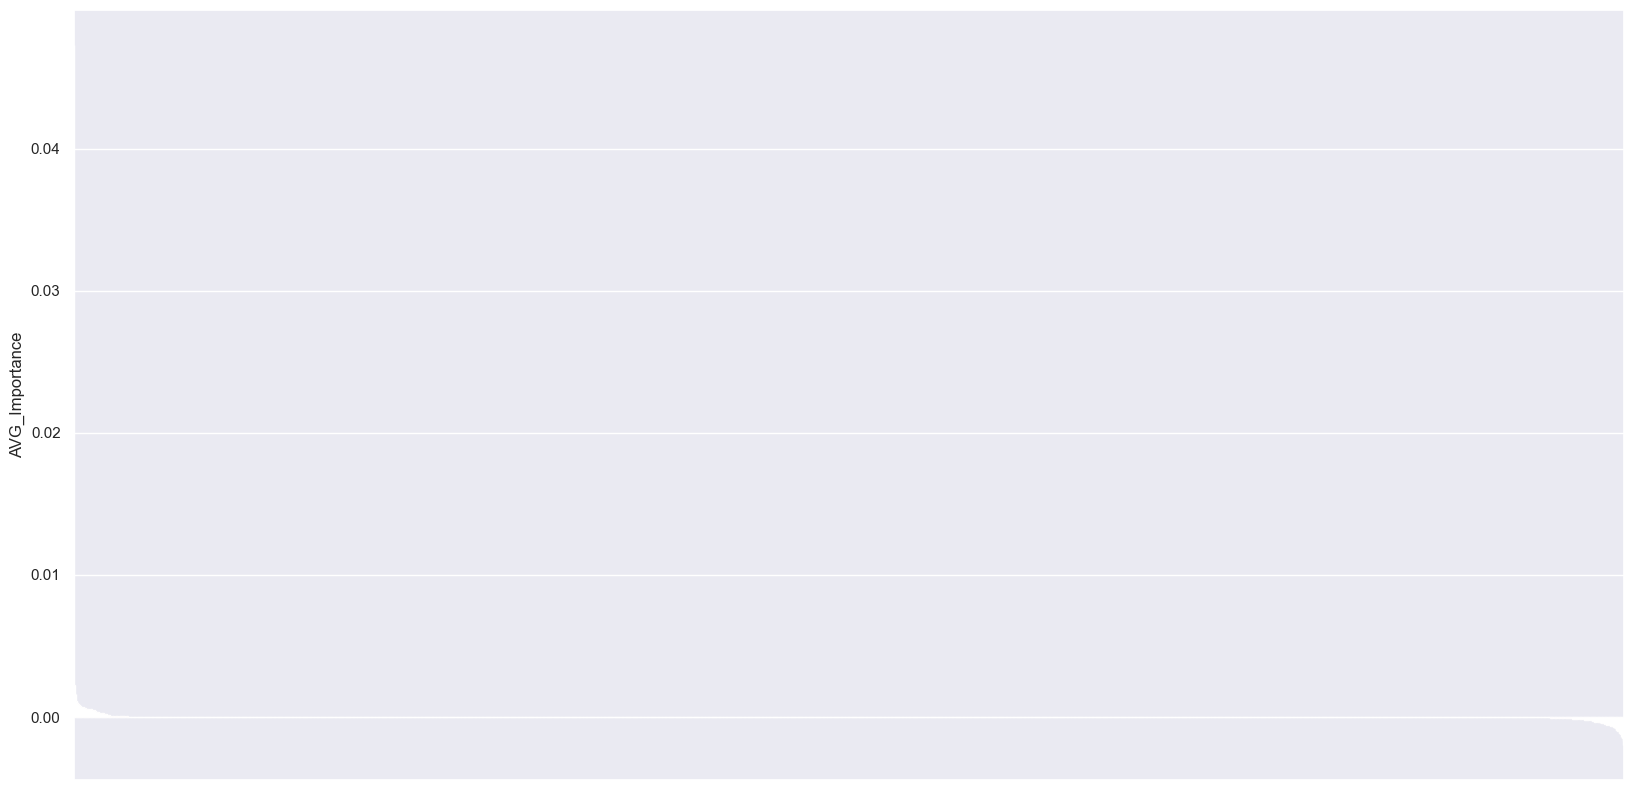

In [28]:
sns.barplot(x=perm.index, y=perm.AVG_Importance)
plt.xticks([])
plt.show()

In [29]:
perm

,AVG_Importance,STD_Importance
col1454,0.047302,0.003947
col2663,0.002222,0.003759
col2365,0.001714,0.000291
col2462,0.001587,0.000651
col2285,0.001143,0.000622
...,...,...
col2328,-0.001397,0.000740
col2172,-0.001460,0.001026
col2171,-0.001460,0.000806
col2654,-0.001714,0.000496


In [30]:
perm.query("AVG_Importance > 0")["AVG_Importance"]

col1454    0.047302
col2663    0.002222
col2365    0.001714
col2462    0.001587
col2285    0.001143
col2390    0.001143
col2221    0.001016
col2063    0.000952
col2589    0.000952
col2220    0.000825
col1967    0.000762
col2403    0.000762
col2456    0.000762
col2360    0.000698
col1979    0.000698
col2376    0.000698
col2041    0.000698
col1991    0.000698
col2626    0.000635
col2316    0.000635
col2144    0.000635
col2086    0.000571
col2284    0.000571
col580     0.000571
col2062    0.000571
col2650    0.000571
col540     0.000571
col2332    0.000571
col2604    0.000571
col2150    0.000571
col2133    0.000571
col480     0.000508
col2164    0.000508
col2040    0.000508
col160     0.000508
col2461    0.000508
col2404    0.000444
col1459    0.000444
col2556    0.000444
col2312    0.000381
col2216    0.000381
col2359    0.000381
col607     0.000381
col2317    0.000381
col2088    0.000317
col1462    0.000317
col2382    0.000317
col2383    0.000317
col1987    0.000317
col2211    0.000317


Let's leave only useful features

In [31]:
perm.query("AVG_Importance > 0")["AVG_Importance"].index.to_list()

['col1454',
 'col2663',
 'col2365',
 'col2462',
 'col2285',
 'col2390',
 'col2221',
 'col2063',
 'col2589',
 'col2220',
 'col1967',
 'col2403',
 'col2456',
 'col2360',
 'col1979',
 'col2376',
 'col2041',
 'col1991',
 'col2626',
 'col2316',
 'col2144',
 'col2086',
 'col2284',
 'col580',
 'col2062',
 'col2650',
 'col540',
 'col2332',
 'col2604',
 'col2150',
 'col2133',
 'col480',
 'col2164',
 'col2040',
 'col160',
 'col2461',
 'col2404',
 'col1459',
 'col2556',
 'col2312',
 'col2216',
 'col2359',
 'col607',
 'col2317',
 'col2088',
 'col1462',
 'col2382',
 'col2383',
 'col1987',
 'col2211',
 'col2158',
 'col2366',
 'col2590',
 'col2410',
 'col2021',
 'col2292',
 'col2588',
 'col2455',
 'col2334',
 'col2188',
 'weekday',
 'col2432',
 'col2198',
 'col2558',
 'col600',
 'col572',
 'col589',
 'col1839',
 'col1228',
 'col2186',
 'col2014',
 'col2567',
 'col2337',
 'col296',
 'col1080',
 'col2595',
 'col424',
 'col520',
 'col2280',
 'col2275',
 'col2636',
 'col1461',
 'col1104',
 'col2237',
 'c

In [32]:
useful_column_indices = get_column_indices(X_train, perm.query("AVG_Importance > 0")["AVG_Importance"].index.to_list())

In [33]:
df_feat_types = pd.DataFrame(X_train.iloc[:, useful_column_indices].dtypes, columns=['dtype']).reset_index(names=['feature_name'])
len(df_feat_types.query("dtype.isin(['object'])")) / len(df_feat_types)

0.10752688172043011

In [34]:
model_without_noise_feat = catboost_model_classifier(X_train.iloc[:, useful_column_indices],
                                                     X_test.iloc[:, useful_column_indices], y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [35]:
y_pred = model_without_noise_feat.predict(X_valid.iloc[:, useful_column_indices])
roc_auc_score(y_valid, y_pred)

0.9145026881720429

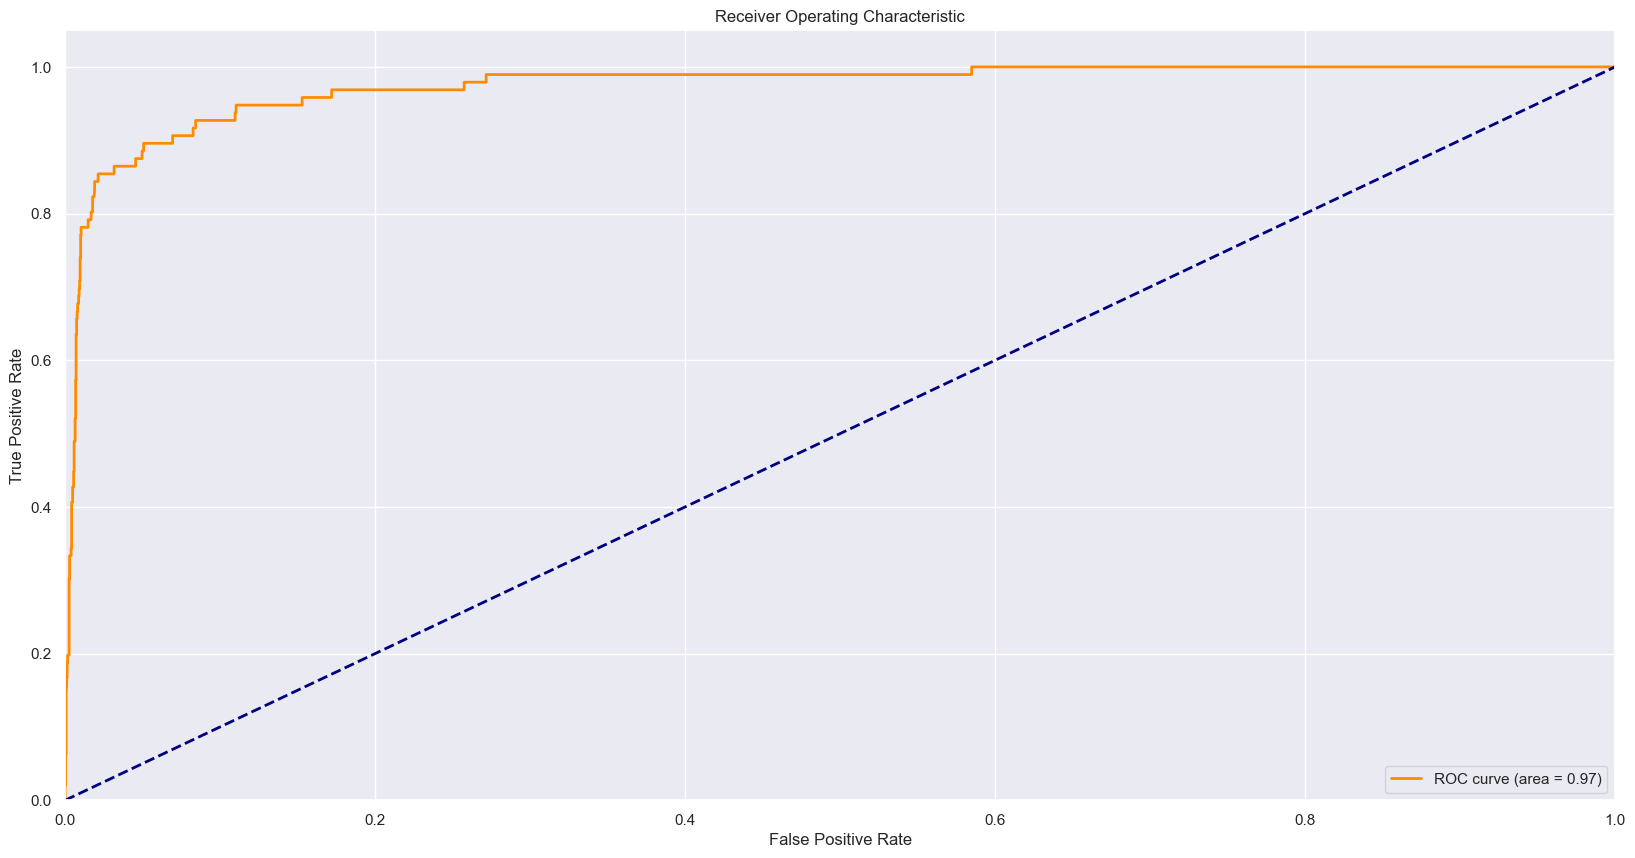

In [36]:
plot_roc_curve(model_without_noise_feat, X_valid.iloc[:, useful_column_indices], y_valid)

# Option 2

In [39]:
model = catboost_model_classifier(X_train, X_test, y_train, y_test)
model.select_features(
    X_train,
    y_train,
    eval_set=(X_valid, y_valid),
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    train_final_model=True,
    logging_level='Silent',
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostError: Model was already fitted. Set train_final_model to False or use not fitted model.

In [ ]:
def get_features_importance_rand_feaut(X_train, y_train, X_valid, y_valid):
    # Add a random feature
    X_train["random"] = np.random.random(size=len(X_train))
    X_valid["random"] = np.random.random(size=len(X_valid))

    # Get categorical features
    categorical_columns = X_train.select_dtypes(exclude=['float64', 'int64']).columns
    categorical_features_indices = get_column_indices(X_train, categorical_columns)

    model = CatBoostClassifier(
        loss_function='Logloss',
        random_seed=42,
        logging_level='Silent',
        max_depth=8,
        iterations=200,
        auto_class_weights='Balanced',
        early_stopping_rounds=20,
    )
    # Train the model
    model.fit(
        X_train,
        y_train,
        eval_set=(X_valid, y_valid),
        cat_features=categorical_features_indices,
    )

    # Get feature importance
    importance = model.feature_importances_

    # Create a dictionary that maps feature names to their importance
    features_importance = {
        name: importance for name, importance in zip(X_train.columns, importance)
    }

    return features_importance


In [ ]:
def calculate_feature_importance(data, target, iterations):
    feature_importances = []

    for i in range(iterations):
        # Create a random variable
        data['random_var'] = np.random.random(size=len(data))

        # Fit a CatBoostClassifier model
        model = CatBoostClassifier(verbose=0, random_state=0)
        model.fit(data, target)

        # Get the feature importance of the random variable
        feature_importance = model.get_feature_importance(prettified=True)
        random_var_importance = feature_importance[feature_importance['Feature Id'] == 'random_var']['Importances'].values[0]

        # Append the feature importance to the list
        feature_importances.append(random_var_importance)

        # Drop the random variable from the dataset
        data = data.drop('random_var', axis=1)
    return feature_importances


In [ ]:
calculate_feature_importance(X_train, y_train, X_valid, y_valid)

# Hyperparameters Tuning

In [ ]:
def objective(search_space):  #x_train, x_test, y_train, y_test, 
    categorical_columns = X_train.select_dtypes(exclude=['float64', 'int64']).columns
    categorical_features_indices = get_column_indices(X_train, categorical_columns)

    cb_model = CatBoostClassifier(
        **search_space,
        loss_function='Logloss',
        auto_class_weights='Balanced',
        early_stopping_rounds=20,
        random_seed=42,
    )

    cb_model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        cat_features=categorical_features_indices,
        plot=True,
        verbose=False
    )
    return {'loss': cb_model.get_best_score()['validation']['Logloss'], 'status': STATUS_OK}

In [ ]:
search_space = {
    'learning_rate': hp.uniform('learning_rate', 0.1, 0.5),
    'iterations': hp.randint('iterations', 100, 1000),
    'l2_leaf_reg': hp.randint('l2_leaf_reg', 1, 10),
    'depth': hp.randint('depth', 4, 10),
    # 'border_count': hp.uniform ('border_count', 32, 255),
}

In [ ]:
best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=100,
    # verbose=False,
)

In [ ]:
hyperparams = space_eval(search_space, best_params)

In [ ]:
with open('hyperparams.pkl', 'wb') as fp:
    pickle.dump(hyperparams, fp)

In [ ]:
params = {
    'learning_rate': hyperparams['learning_rate'],
    'iterations': hyperparams['iterations'],
    'depth': hyperparams['depth'],
    'loss_function': 'Logloss',
    'l2_leaf_reg': hyperparams['l2_leaf_reg'],
    'eval_metric': 'Logloss',
    'early_stopping_rounds': 20,
    'random_seed': 42,
}

In [ ]:
categorical_columns = X_train.select_dtypes(exclude=['float64', 'int64']).columns
categorical_features_indices = get_column_indices(X_train, categorical_columns)
model = CatBoostClassifier(**params)
model.fit(X=X_train, y=y_train, eval_set=(X_valid, y_valid), verbose=250, cat_features=categorical_features_indices)
y_pred = model.predict(X_valid)
roc_auc_score(y_valid, y_pred)

# Cross-Validation

In [ ]:
from catboost import cv

# parameters for training inside cv:
params = {
    'loss_function': 'Logloss',
    'iterations': 100,
    'custom_loss': 'AUC',
    'learning_rate': 0.5,
}

In [ ]:
def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-Logloss-mean'].min()
    best_iter = cv_data['test-Logloss-mean'].values.argmin()

    print('Best validation Logloss score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-Logloss-std'][best_iter],
        best_iter)
    )


In [ ]:
train_pool = Pool(data=X_train, label=y_train, cat_features=get_column_indices(X_train, categorical_columns))
val_pool = Pool(data=X_valid, label=y_valid, cat_features=get_column_indices(X_valid, categorical_columns))

In [ ]:
cv_data = cv(
    params=params,
    pool=train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

print_cv_summary(cv_data)

In [ ]:
cv_data

# Validation